✅ Validation R² : 0.6493
✅ Validation RMSE: 0.153
✅ Validation MAE : 0.1142


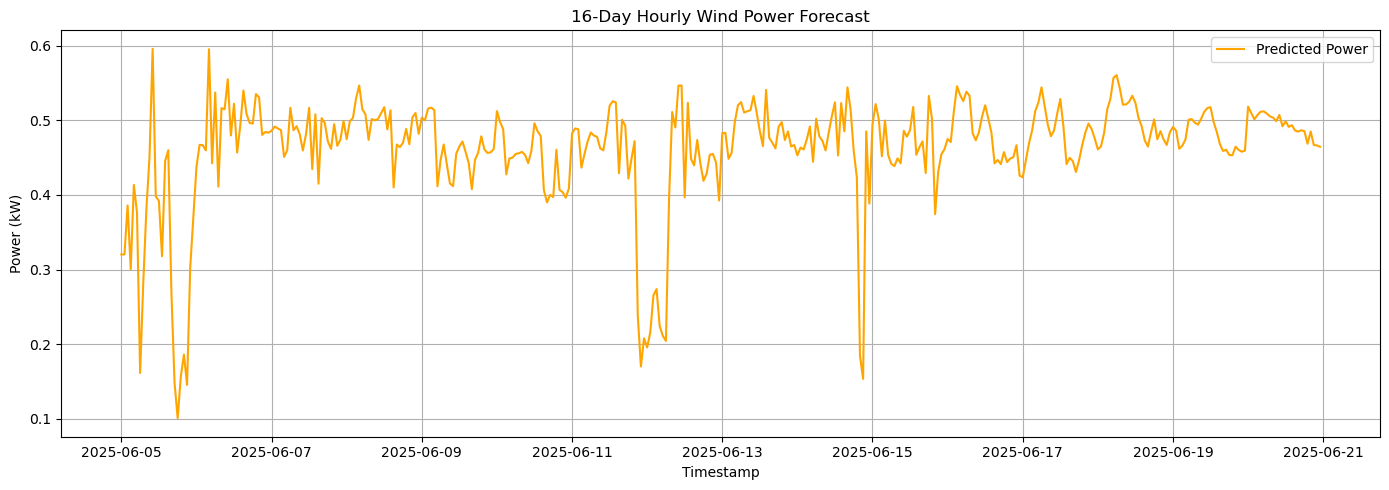

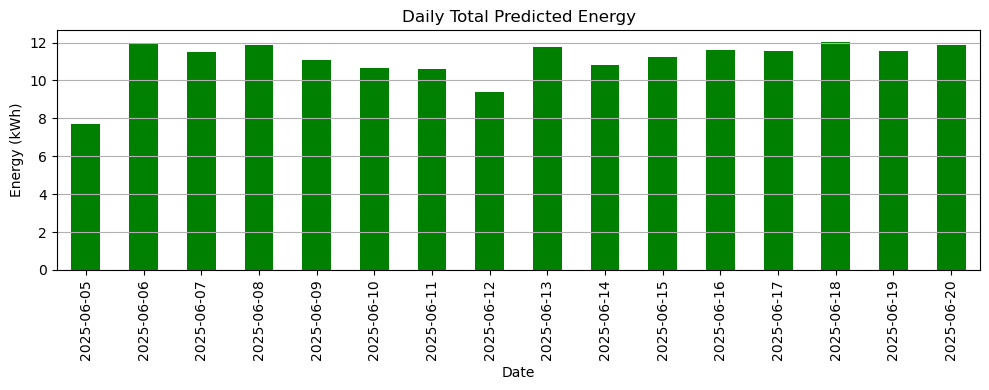

In [1]:
# 1. Imports
# --------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# --------------------------------------------
# 2. Load & prepare HISTORICAL data (training)
# --------------------------------------------
hist_files = ['Location1.csv', 'Location2.csv', 'Location3.csv', 'Location4.csv']
hist_df = pd.concat([pd.read_csv(f) for f in hist_files], axis=0, ignore_index=True)

# Drop unused columns
hist_df.drop(columns=['windspeed_10m', 'winddirection_10m', 'winddirection_100m'], inplace=True)

# Rename → uniform schema
hist_df.rename(columns={
    'Time': 'datetime',
    'temperature_2m': 'temp',
    'relativehumidity_2m': 'humidity',
    'dewpoint_2m': 'dew',
    'windspeed_100m': 'windspeed',
    'windgusts_10m': 'windgust',
    'Power': 'power'
}, inplace=True)

# Time features
hist_df['datetime'] = pd.to_datetime(hist_df['datetime'], errors='coerce')
hist_df.dropna(subset=['datetime'], inplace=True)
hist_df['hour']  = hist_df['datetime'].dt.hour
hist_df['day']   = hist_df['datetime'].dt.day
hist_df['month'] = hist_df['datetime'].dt.month
hist_df.drop(columns=['datetime'], inplace=True)

# Split X / y
X_hist = hist_df.drop(columns=['power'])
y_hist = hist_df['power']

# Scale features
scaler = StandardScaler()
X_hist_scaled = scaler.fit_transform(X_hist)

# Train / validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_hist_scaled, y_hist, test_size=0.2, random_state=42)

# --------------------------------------------
# 3. Train Extra Trees Model (no tuning)
# --------------------------------------------
model = ExtraTreesRegressor(
    n_estimators=100,       # Increased trees for better accuracy
    max_depth=None,         # Let the trees grow fully
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)
# Validation check
y_val_pred = model.predict(X_val)
# Use the built-in round() function or np.round() instead of the method
print("✅ Validation R² :", round(r2_score(y_val, y_val_pred), 4))
print("✅ Validation RMSE:", round(np.sqrt(mean_squared_error(y_val, y_val_pred)), 4))
print("✅ Validation MAE :", round(mean_absolute_error(y_val, y_val_pred), 4))

# --------------------------------------------
# 4. Load & clean FUTURE data
# --------------------------------------------
future_file = 'future_data.csv'
headers = ['time','temp','humidity','dew',
           'windspeed10m','windspeed','winddir10','winddir120','windgust']
future_raw = pd.read_csv(future_file, skiprows=3, names=headers)

# Drop duplicate header row
future_raw = future_raw[future_raw['time'] != 'time']

# Convert types
num_cols = ['temp','humidity','dew','windspeed10m','windspeed','windgust']
future_raw[num_cols] = future_raw[num_cols].apply(pd.to_numeric, errors='coerce')
future_raw['time'] = pd.to_datetime(future_raw['time'], errors='coerce')
future_raw.dropna(subset=['time'], inplace=True)

# Add features
future_raw['hour']  = future_raw['time'].dt.hour
future_raw['day']   = future_raw['time'].dt.day
future_raw['month'] = future_raw['time'].dt.month

# Select only required features
future_X = future_raw[['temp', 'humidity', 'dew', 'windspeed', 'windgust', 'hour', 'day', 'month']]
future_time = future_raw['time']

# Standardize
X_future_scaled = scaler.transform(future_X)

# --------------------------------------------
# 5. Predict 16-day hourly forecast
# --------------------------------------------
future_pred = model.predict(X_future_scaled)

# --------------------------------------------
# 6. Visualize
# --------------------------------------------
# Line plot (hourly)
plt.figure(figsize=(14, 5))
plt.plot(future_time, future_pred, label='Predicted Power', color='orange', linewidth=1.5)
plt.title('16-Day Hourly Wind Power Forecast')
plt.xlabel('Timestamp')
plt.ylabel('Power (kW)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Daily bar chart
daily_total = pd.DataFrame({
    'date': future_time.dt.date,
    'power': future_pred
}).groupby('date')['power'].sum()

plt.figure(figsize=(10, 4))
daily_total.plot(kind='bar', color='green')
plt.title('Daily Total Predicted Energy')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [4]:
import joblib
joblib.dump(model, "wind_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Now Go to live power forecast file and run ")

Now Go to live power forecast file and run 
